In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os
import sys
import pandas as pd

import pickle
import glob
import re

In [6]:
def get_stats(jobnames, root="/checkpoint/yuandong/jobs", name_filter=None):
    all_stats = []
    for job in jobnames:
        for filename in glob.glob(os.path.join(root, job, "*.pickle")):
            if name_filter is not None and re.search(name_filter, filename) is None:
                continue

            stats = pickle.load(open(filename, "rb"))
            all_stats.append(stats)

    return all_stats

#stats = pickle.load(open("/private/home/yuandong/dl_theory2/save-nn-234-trial1.pickle", "rb"))
#stats = pickle.load(open("/private/home/yuandong/dl_theory2/save-nn-714-trial0.pickle", "rb"))

# print(len(stats["data"]))
# print(stats["cmdline"])
# stats = stats["data"]

In [8]:
def plot_corr(data):
    res = dict()
    
    res["epoch"] = list(range(len(data)))
    
    res["loss"] = np.array([s["eval_loss"] for s in data])
    res["accuracy"] = np.array([s["eval_accuracy"] for s in data])
    
    num_layer = len(data[0]["eval_corrs"])
    
    for layer in range(num_layer):
        corrs = np.zeros(len(data))
        for i, s in enumerate(data):
            sorted_corrs = s["eval_corrs"][layer].sort(0)[0]
            max_corrs = sorted_corrs[-1,:]
            corrs[i] = max_corrs.mean().item()
        res[f"corr-layer-{layer}"] = corrs

    return res

In [7]:
class PlotData:
    def __init__(self, name):
        self.d = dict()
        self.name = name
        self.display_multi_curve = 'std'
    
    def add(self, d):
        # Add to key value pairs
        # all v needs to be numpy array. 
        for k, v in d.items():
            if k not in self.d:
                self.d[k] = [v]
            else:
                # save them
                self.d[k].append(v)
    
    def plot(self, plt, k1, k2s, colors, name2label=dict()):
        assert k1 in self.d
        
        x = self.d[k1][0]
        
        for k2, c in zip(k2s, colors):
            y = self.d[k2]
            label = name2label.get(k2, k2)
            if len(y) > 1:
                # Multiple series. Compute their min/max.
                ys = np.stack(y, axis=1)
                mean_y = np.mean(ys, axis=1)
                plt.plot(x, mean_y, color=c, label=label)
                
                if self.display_multi_curve == 'std':
                    std_y = np.std(ys, axis=1)
                    # draw error bar. 
                    plt.fill_between(x, mean_y - std_y, mean_y + std_y, color=c, alpha=0.2)
                elif self.display_multi_curve == 'minmax':
                    min_y = np.min(ys, axis=1)
                    max_y = np.max(ys, axis=1)
                    plt.fill_between(x, max_y, min_y, color=c, alpha=0.2)
            else:
                plt.plot(x, y[0], color=c, label=label)
            
    def __getitem__(self, k):
        return self.d[k]
    
class ArgFilter:
    def __init__(self, **kwargs):
        self.spec = kwargs
        
    def __getitem__(self, k):
        return self.spec[k]
        
    def __hash__(self):
        return hash(tuple(sorted(self.spec.items())))
        
    def info(self):
        return "-".join([ f"{k}={v}" for k, v in self.spec.items()])
    
    def check(self, args):
        if isinstance(args, ArgFilter):
            d = args.spec
        elif isinstance(args, dict):
            d = args
        else:
            d = args.__dict__
            
        for k, v in self.spec.items():
            if not k in d or d[k] != v:
                return False

        return True

In [9]:
'''
jobnames = [
    "theory_different_multi_no_sep", 
    "theory_different_multi", 
    "theory_different_multi_cnn", 
    "theory_different_multi_cnn_no_sep"
]
'''

name_filter = re.compile("trial0")

jobnames = [ "theory_over_params", "theory_over_params_no_bn" ]
all_stats = get_stats(jobnames)

In [10]:
all_plot_data = dict()

for node_multi in (1, 2, 5, 10, 20, 50):
    for use_cnn in (False, True):
        for no_sep in (False, True):
            for bn in (False, True):
                filters = ArgFilter(node_multi=node_multi,use_cnn=use_cnn,no_sep=no_sep, bn=bn, bn_affine=bn)

                count = 0

                # Arg Filter.
                plot_data = PlotData(filters.info())
                for stats in all_stats:
                    if filters.check(stats["args"]):
                        # print(stats["args"])
                        # dict(epoch =, accuracy=, loss=, corr-layer-4=)
                        try:
                            plot_data.add(plot_corr(stats["data"]))
                            count += 1
                        except:
                            pass

                print(f"{filters.info()}: #experiments: {count}")
                all_plot_data[filters] = plot_data

node_multi=1-use_cnn=False-no_sep=False-bn=False-bn_affine=False: #experiments: 31
node_multi=1-use_cnn=False-no_sep=False-bn=True-bn_affine=True: #experiments: 32
node_multi=1-use_cnn=False-no_sep=True-bn=False-bn_affine=False: #experiments: 32
node_multi=1-use_cnn=False-no_sep=True-bn=True-bn_affine=True: #experiments: 32
node_multi=1-use_cnn=True-no_sep=False-bn=False-bn_affine=False: #experiments: 20
node_multi=1-use_cnn=True-no_sep=False-bn=True-bn_affine=True: #experiments: 32
node_multi=1-use_cnn=True-no_sep=True-bn=False-bn_affine=False: #experiments: 25
node_multi=1-use_cnn=True-no_sep=True-bn=True-bn_affine=True: #experiments: 32
node_multi=2-use_cnn=False-no_sep=False-bn=False-bn_affine=False: #experiments: 32
node_multi=2-use_cnn=False-no_sep=False-bn=True-bn_affine=True: #experiments: 32
node_multi=2-use_cnn=False-no_sep=True-bn=False-bn_affine=False: #experiments: 31
node_multi=2-use_cnn=False-no_sep=True-bn=True-bn_affine=True: #experiments: 32
node_multi=2-use_cnn=True-

/private/home/yuandong/miniconda3/envs/go10/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


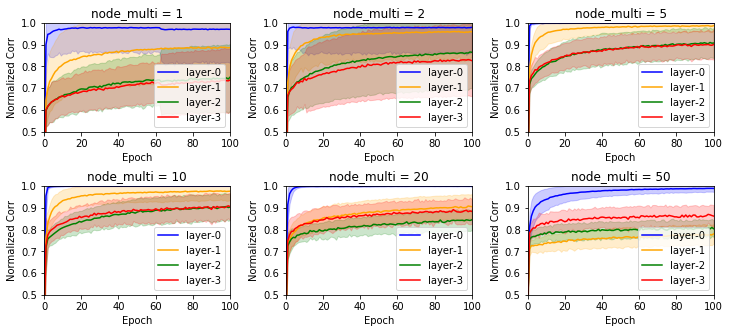

In [24]:
f = ArgFilter(use_cnn=False, no_sep=False, bn=False)

keys = [ f"corr-layer-{layer}" for layer in range(4) ]
keys2labels = { f"corr-layer-{layer}" : f"layer-{layer}" for layer in range(4) }
colors = ["b", "orange", "green", "red"]

plt.figure(figsize=(12, 5))
# plt.rcParams.update({'font.family': 'Verdana'})
count = 1
for args, plot_data in all_plot_data.items():
    # print(args.info())
    if not f.check(args):
        continue
        
    plt.subplot(2, 3, count)
    count += 1
        
    # plt.subplot(1, 3, 1)
    #     plt.plot(losses)
    #     plt.xlabel('Epoch')
    #     plt.ylabel('Loss in Evaluation')

    #     plt.xlabel('Epoch')
    #     plt.ylabel('Accuracy in Evaluation')

    #    plt.subplot(1, 3, 3)

    plot_data.plot(plt, "epoch", keys, colors, name2label=keys2labels)

    plt.axis([0, np.max(plot_data["epoch"][0]), 0.5, 1])
    plt.xlabel('Epoch')
    plt.ylabel('Normalized Corr')
    plt.title(f'node_multi = {args.spec["node_multi"]}')
    plt.legend()
    plt.subplots_adjust(wspace=0.3, hspace=0.5)

plt.savefig(f"gaussian_different_multi_no_bn.pdf")
#plt.savefig(f"gaussian_cnn_different_multi.pdf")
#plt.show()

In [4]:
jobnames = [ "theory_thm5_2" ]
all_stats = get_stats(jobnames)

KeyboardInterrupt: 

In [6]:
len(all_stats)

0